<a href="https://colab.research.google.com/github/iiHadeeel/AI/blob/main/MentalHealthClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mental Health Classification

In [109]:
import numpy as np
import nltk
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from PIL import Image
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.metrics import *
from keras.layers import GRU
import numpy as np
import pandas as pd
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from keras.preprocessing.text import Tokenizer
import random
from sklearn.model_selection import train_test_split
from sklearn import pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (accuracy_score,precision_recall_fscore_support,confusion_matrix,ConfusionMatrixDisplay)
from keras.utils import plot_model
from keras import Model
from keras.models import Sequential
from keras.layers import (Conv1D,Dense,Dropout,Embedding,Flatten,GlobalMaxPooling1D,Input,LSTM,TextVectorization)
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from keras.optimizers import Adam, RMSprop
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Exploring

In [3]:
 #this is used to copy the path of the dataset from the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#replace this with the path of the csv
df= pd.read_csv("/content/mental_health.csv")

In [7]:
df.head()

,text,label
0,dear american teens question dutch person hear...,0
1,nothing look forward lifei dont many reasons k...,1
2,music recommendations im looking expand playli...,0
3,im done trying feel betterthe reason im still ...,1
4,worried year old girl subject domestic physic...,1


In [8]:
print(' -------------------------------- Dataset general Info --------------------------------')
df.info()
print(' -------------------------------- Missing values check --------------------------------')
df.isna().any() # checking for missing values

 -------------------------------- Dataset general Info --------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27977 entries, 0 to 27976
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    27977 non-null  object
 1   label   27977 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 437.3+ KB
 -------------------------------- Missing values check --------------------------------


text     False
label    False
dtype: bool

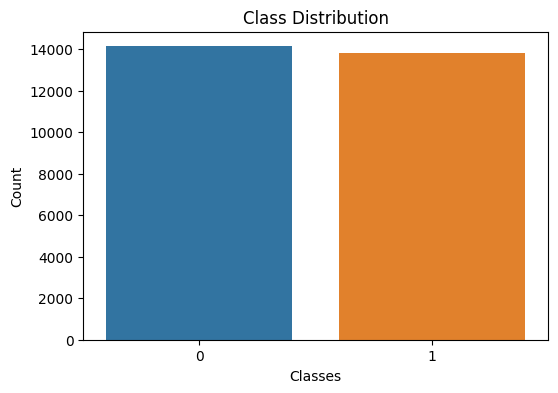

In [11]:
# Class Distribution
class_counts = df['label'].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()


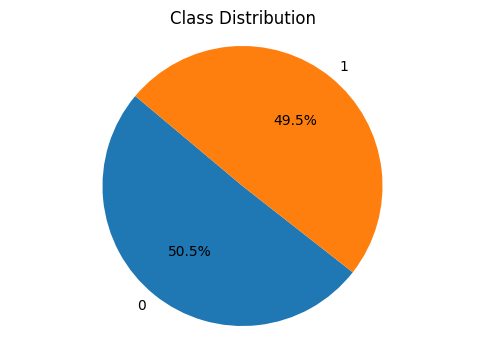

In [12]:
plt.figure(figsize=(6, 4))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Class Distribution')
plt.show()


In [13]:
print(' ------------------------------------- Labels count -----------------------------------')
df["label"].value_counts() #labels count [1: the person has a mental health issue 0: the person doesn’t]

 ------------------------------------- Labels count -----------------------------------


0    14139
1    13838
Name: label, dtype: int64

In [14]:
print(' ------------------------ Number of words and unique words ----------------------------')
AllWords =  ' '.join(df['text'].values)
UniqueWords= set(AllWords.lower().split())
print(f"The number of words in the Dataset: {len(AllWords.split())} \nThe number of unique words in the Dataset: {len(UniqueWords)}")

 ------------------------ Number of words and unique words ----------------------------
The number of words in the Dataset: 2007613 
The number of unique words in the Dataset: 72649


In [15]:
print(' -------------------------- The frequency of each word -------------------------------')
WordsCounter = pd.value_counts(AllWords.split())
WordsCounter.sort_values(ascending=False) # sorted from most frequent

 -------------------------- The frequency of each word -------------------------------


im                 34720
like               22300
want               17299
know               15475
feel               14508
                   ...  
minstrelization        1
suggestsbr             1
trevilian              1
cultists               1
bridei                 1
Length: 72649, dtype: int64

 ------------------------- Plotting the first 20 most frequent words ---------------------------------


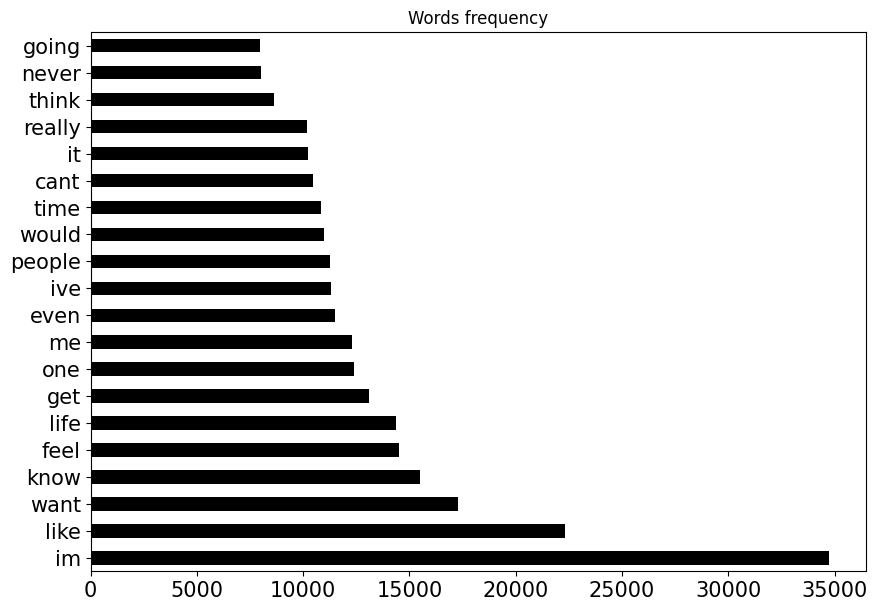

In [16]:
print(' ------------------------- Plotting the first 20 most frequent words ---------------------------------')
WordsCounter[:20].plot.barh(figsize=(10,7),fontsize=15,colormap="bone",title="Words frequency").title.set_size(12)

## Data Preprocessing

## Handling missing values

In [17]:
# Load your dataset (replace 'your_dataset.csv' with the actual file path)
data = pd.read_csv("/content/mental_health.csv")

# Check for missing values
missing_values = data.isnull().sum()

# Print columns with missing values and their counts
print("Columns with missing values:")
print(missing_values[missing_values > 0])

# Remove rows with missing values
data_cleaned = data.dropna()

# Save the cleaned data to a new CSV file
data_cleaned.to_csv('cleaned_dataset.csv', index=False)


Columns with missing values:
Series([], dtype: int64)


## **Stop Word Removal**

In [18]:
# Get the list of stopwords
stop_words = set(stopwords.words('english'))

# Function to remove stop words from a text
def remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

# Apply stop word removal to the 'text' column
df['text_without_stopwords'] = df['text'].apply(remove_stopwords)

# Save the text without stopwords to a CSV file
path = "/content/Stop_words_removal_dataset.csv"
with open(path, 'w', encoding = 'utf-8-sig') as f:
    df[['text', 'text_without_stopwords']].to_csv(f, index=False)

## **Lemmatization**

In [19]:
# Instantiate the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Function to perform lemmatization on a text
def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

# Apply lemmatization to the 'text' column
df['lemmatized_text'] = df['text_without_stopwords'].apply(lemmatize_text)

# Save the lemmatized text to a CSV file
path = "/content/lemmatized_text.csv"
with open(path, 'w', encoding = 'utf-8-sig') as f:
    df[['text', 'lemmatized_text']].to_csv(f, index=False)

## **Tokenization**

In [21]:
# Tokenize the text column
df['tokenized_text'] = df['lemmatized_text'].apply(word_tokenize)

# Print the tokenized text
for index, row in df.iterrows():
    print(f"Original Text: {row['lemmatized_text']}")
    print(f"Tokenized Text: {row['tokenized_text']}")
    print("--------------------")
# Save the tokenized text to a CSV file
path = '/content/tokenized_text.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
    df[['text', 'tokenized_text']].to_csv(f, index=False)

Streaming output truncated to the last 5000 lines.
--------------------
Original Text: feeling like people abandon feeling alone like ill never someone cuddle withi get feeling people want abandon think peolpe abandoning ill want kill want people abandon ignore really want uncared want kill every time think im tired alone really want someone cuddle ill never able actually find someone cuddle would want cuddle year old guy spectrum guess hopeless
Tokenized Text: ['feeling', 'like', 'people', 'abandon', 'feeling', 'alone', 'like', 'ill', 'never', 'someone', 'cuddle', 'withi', 'get', 'feeling', 'people', 'want', 'abandon', 'think', 'peolpe', 'abandoning', 'ill', 'want', 'kill', 'want', 'people', 'abandon', 'ignore', 'really', 'want', 'uncared', 'want', 'kill', 'every', 'time', 'think', 'im', 'tired', 'alone', 'really', 'want', 'someone', 'cuddle', 'ill', 'never', 'able', 'actually', 'find', 'someone', 'cuddle', 'would', 'want', 'cuddle', 'year', 'old', 'guy', 'spectrum', 'guess', 'hopeles

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Tokenized Text: ['wierd', 'story', 'found', 'looking', 'copypasta', 'garden', 'gnome', 'noggin', 'clontith', 'walking', 'around', 'street', 'suddenly', 'alleyway', 'find', 'among', 'u', 'secks', 'anime', 'girl', 'gnome', 'asks', 'wat', 'amung', 'u', 'among', 'u', 'among', 'u', 'responds', 'saying', 'secks', 'wit', 'anime', 'girl', 'ok', 'said', 'gnome', 'anime', 'girl', 'cummed', 'ok', 'im', 'cumming', 'wait', 'said', 'gnome', 'seems', 'someone', 'watching', 'secks', 'besides', 'point', 'gnome', 'ahh', 'thats', 'kinda', 'sus', 'said', 'among', 'u', 'drip', 'tip', 'finally', 'impostor', 'reveals', 'himslef', 'jerma', 'sus', 'yes', 'responds', 'evel', 'jerma', 'sus', 'oh', 'said', 'anime', 'girl', 'cumming', 'every', 'millisecond', 'he', 'gon', 'na', 'kill', 'u', 'said', 'amung', 'u', 'creamping', 'anime', 'girl', 'pussy', 'everything', 'seemed', 'end', 'suddenly', 'hero', 'emerges', 'darkness', 'reciting', 'banishing', 'word', 'said', 'hero', 'pepe', 'frog', 'pepe', 'recited', 'word', '

## **Stemming**

In [22]:
# # Instantiate the PorterStemmer
# stemmer = PorterStemmer()

# # Function to perform stemming on a text
# def stem_text(text):
#     tokens = word_tokenize(text)
#     stemmed_tokens = [stemmer.stem(token) for token in tokens]
#     stemmed_text = ' '.join(stemmed_tokens)
#     return stemmed_text


# # Apply stemming to the 'text' column
# df['stemmed_text'] = df['text'].apply(stem_text)

# # Save the stemmed text to a new CSV file
# path = '/content/stemmed_text.csv'
# with open(path, 'w', encoding = 'utf-8-sig') as f:
#     df[['text', 'stemmed_text']].to_csv(f, index=False)

## **Handling Imbalanced Data**

In [23]:
# Split the dataset into features (X) and target variable (y)
X = df['lemmatized_text']
y = df['label']


In [27]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(X)
tok = tokenizer.texts_to_sequences(X)
max_len = max(len(item) for item in tok)
print(max_len)
for item in tok:
    while len(item) < max_len:
        item.append(0)

padded_np = np.array(tok)
padded_np.shape

2555


(27977, 2555)

## **Visualization**

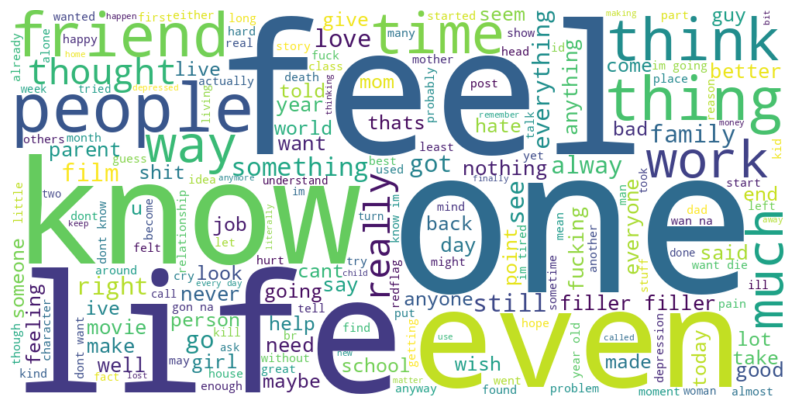

In [28]:
text_corpus = ' '.join(df['lemmatized_text'].values)
# Create a WordCloud object
wordcloud = WordCloud(width=1000, height=500, background_color='White').generate(text_corpus)
# Display the word cloud where the size of the keywords is relatedto the frequency
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')#displays the word cloud image
plt.axis("off") #hides the axis labels
plt.show() #displays the word cloud plot

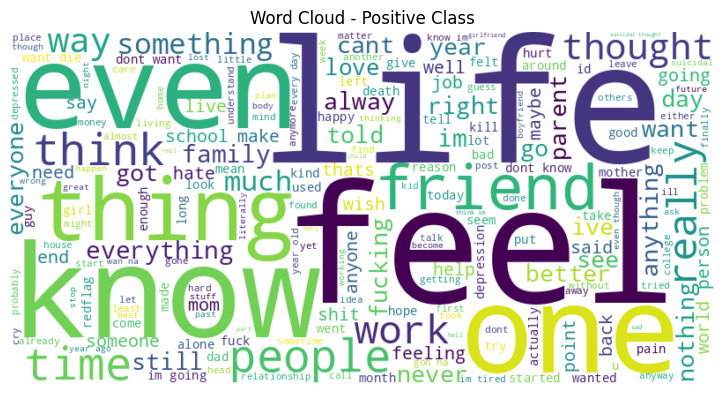

In [29]:
# WordCloud for + Class
positive_words = ' '.join(df[df['label'] == 1]['lemmatized_text'])
negative_words = ' '.join(df[df['label'] == 0]['lemmatized_text'])

plt.figure(figsize=(20, 7))

plt.subplot(1, 2, 1)
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_words)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Word Cloud - Positive Class')
plt.axis("off")
plt.show()

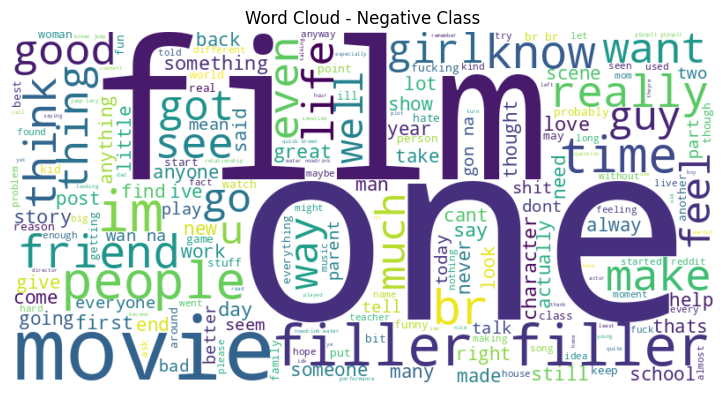

In [ ]:
# WordCloud for - Class
plt.figure(figsize=(20, 7))
plt.subplot(1, 2, 2)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_words)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Word Cloud - Negative Class')
plt.axis("off")

plt.show()

In [30]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply Random Oversampling to handle imbalanced data
oversampler = RandomOverSampler(random_state=42)
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train.values.reshape(-1, 1), y_train)

# Convert the oversampled data back to DataFrame
df_train_oversampled = pd.DataFrame({
    'text': X_train_oversampled.flatten(),
    'label': y_train_oversampled
})

# Save the class distribution after oversampling to a CSV file
class_distribution_oversampled = df_train_oversampled['label'].value_counts().reset_index()
class_distribution_oversampled.columns = ['label', 'count']
path = '/content/class_distribution_oversampled.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
    class_distribution_oversampled.to_csv(f, index=False)

## **Vectorization**

In [31]:

sentence_length = []
for sentence in X_train:
    sentence_length.append(len(sentence.split(' ')))
print(sentence_length[:10])

[138, 27, 18, 10, 219, 187, 56, 8, 28, 29]


In [32]:
percentiles = [0, 5, 10, 25, 50, 75, 90, 95, 99, 100]
percentiles_dict = {}
for percentil in percentiles:
    percentiles_dict[str(percentil) + "th percentil"] = np.percentile(sentence_length, percentil)
pd.DataFrame(percentiles_dict, index=["Percentiles"]).T

,Percentiles
0th percentil,1.0
5th percentil,6.0
10th percentil,8.0
25th percentil,15.0
50th percentil,36.0
75th percentil,83.0
90th percentil,161.0
95th percentil,231.0
99th percentil,455.2
100th percentil,2555.0


In [33]:
vocab_size = 70000
max_sentence_length = 83

text_vectorizer = TextVectorization(max_tokens=vocab_size,output_sequence_length=max_sentence_length)
text_vectorizer.adapt(X_train)
text_vectorizer.adapt(X_test)
vectorizerd_text = text_vectorizer(X_train)
vectorizerd_text2 = text_vectorizer(X_test)
text_vectorizer.get_config()

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None, None),
 'max_tokens': 70000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 83,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 26086}

In [34]:
vocab = text_vectorizer.get_vocabulary()
vocab[:10]

['', '[UNK]', 'im', 'like', 'want', 'feel', 'know', 'life', 'get', 'one']

In [37]:
test_sentence = random.choice(X_train)
vectorized_sentence = text_vectorizer([test_sentence])
print(test_sentence)
print(vectorized_sentence)
print(vectorized_sentence.shape)

going medsi feel exactly taking every day three month still wake middle night sobbing panicking wake boyfriend get angry work early morning think ive wanted die much today since last time oded therapist officially dodging week ive gotten drunk andor high every night last two week come shit even get hungover anymore im numbing point week ago mom told shed rather dead failure im never going good enough boyfriend told today he going town th th visit friend birthday th think im going commit birthday like originally planned month ago friend mom told hardest day sister birth date death date itll easier brother day itll birthday present guess im supposed work morning think ill call im fucking miserable cant move bed right
tf.Tensor(
[[   24     1     5   723   249    55    20   374    90    42   336   589
    133  5342  3495   336   265     8   415    49   635   395    21    13
    114    65    27   155    76    70    10 17409   368  2166     1   117
     13   430   583  2065   214    55   13

In [38]:
dataset = tf.data.Dataset.from_tensor_slices((vectorizerd_text, y_train))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(32)
dataset = dataset.prefetch(8)
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))
len(train), len(val), len(test)

(489, 140, 70)

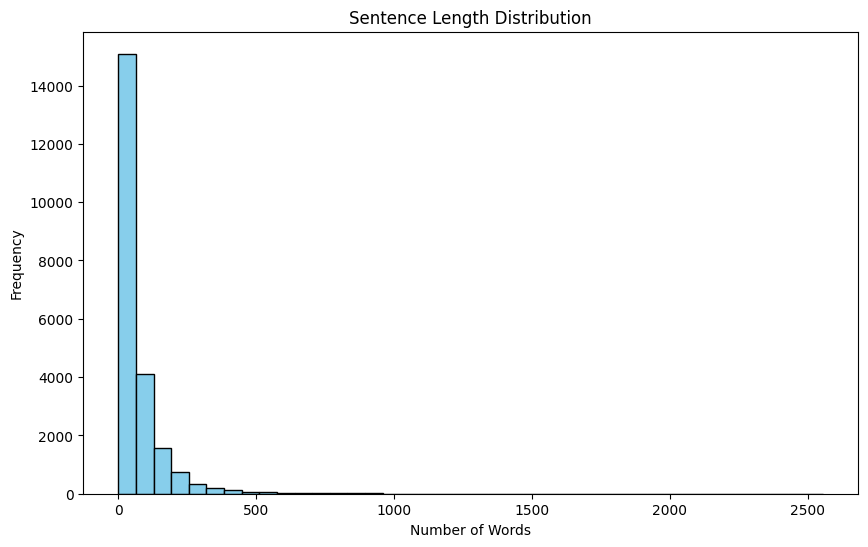

In [39]:
# Sentence Length Distribution
plt.figure(figsize=(10, 6))
plt.hist(sentence_length, bins=40, color='skyblue', edgecolor='black')
plt.title('Sentence Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

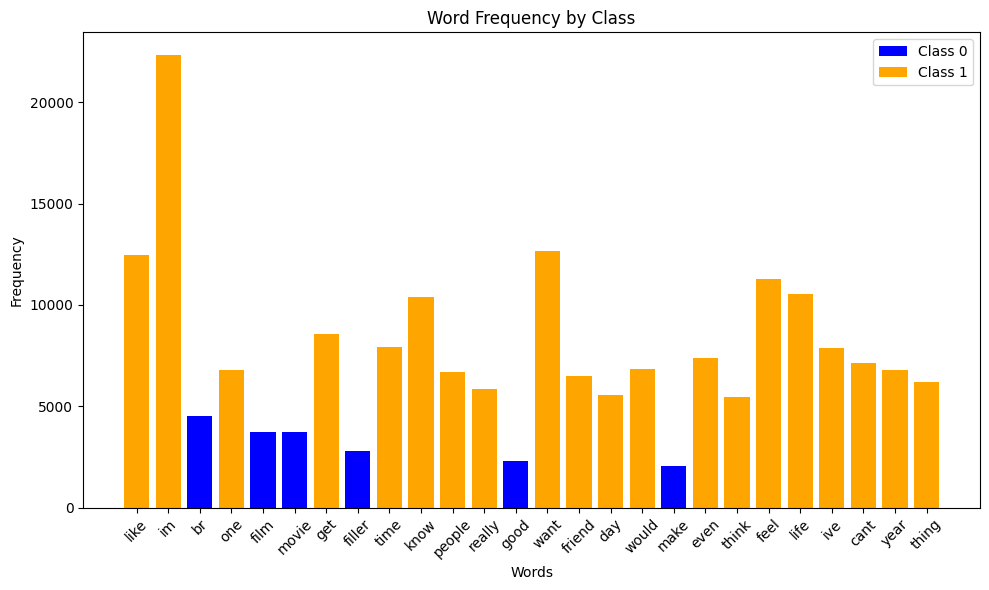

In [40]:
#Word Frequency by Class

# Create a DataFrame combining the text and labels
data = pd.DataFrame({'text': X_train, 'label': y_train})

# Separate the data into two DataFrames based on class labels
class_0_data = data[data['label'] == 0]
class_1_data = data[data['label'] == 1]

# Function to calculate word frequency
def calculate_word_frequency(text_list):
    word_frequency = {}
    for text in text_list:
        words = text.split()
        for word in words:
            if word in word_frequency:
                word_frequency[word] += 1
            else:
                word_frequency[word] = 1
    return word_frequency

# Calculate word frequency for each class
class_0_word_frequency = calculate_word_frequency(class_0_data['text'])
class_1_word_frequency = calculate_word_frequency(class_1_data['text'])

# Convert word frequency dictionaries to DataFrames
class_0_word_frequency_df = pd.DataFrame(list(class_0_word_frequency.items()), columns=['Word', 'Frequency'])
class_1_word_frequency_df = pd.DataFrame(list(class_1_word_frequency.items()), columns=['Word', 'Frequency'])

# Sort DataFrames by frequency
class_0_word_frequency_df = class_0_word_frequency_df.sort_values(by='Frequency', ascending=False)
class_1_word_frequency_df = class_1_word_frequency_df.sort_values(by='Frequency', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_0_word_frequency_df['Word'][:20], class_0_word_frequency_df['Frequency'][:20], color='blue', label='Class 0')
plt.bar(class_1_word_frequency_df['Word'][:20], class_1_word_frequency_df['Frequency'][:20], color='orange', label='Class 1')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequency by Class')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## **LSTM model**

In [51]:
n_words=70000
n_input=83

model_lstm=Sequential()
model_lstm.add(Embedding(n_words,32))
model_lstm.add(LSTM(32, activation='tanh'))
model_lstm.add(Dense(1, activation='sigmoid'))

In [128]:
model_lstm.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=["accuracy"])
# Checking summary
model_lstm.summary()

model_LSTM_history = model_lstm.fit(vectorizerd_text,y_train,epochs=5,validation_data=(vectorizerd_text2,y_test))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          2240000   
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,248,353
Trainable params: 2,248,353
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
700/700 [==============================] - 53s 75ms/step - loss: 0.0149 - accuracy: 0.9948 - val_loss: 0.5198 - val_accuracy: 0.8914
Epoch 2/5
700/700 [==============================] - 45s 64ms/step - loss: 0.0080 - accuracy: 0.9973 - val_loss: 0.5897 - val_accuracy: 0.8946
Epoch 3/5
700/700 [===

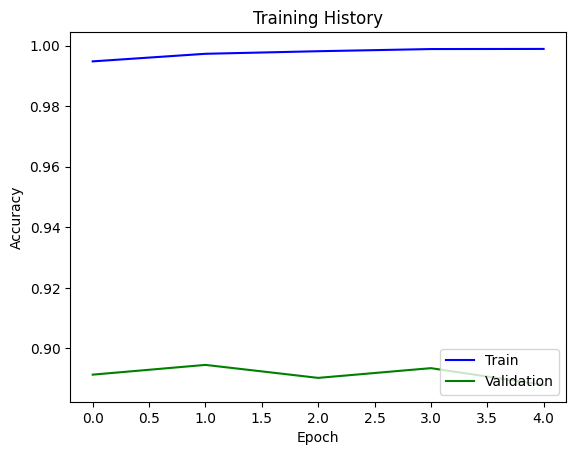

In [129]:
plt.plot(model_LSTM_history.history['accuracy'], c="b")
plt.plot(model_LSTM_history.history['val_accuracy'], c="g")
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [130]:
predictions = model_lstm.predict(vectorizerd_text2)
y_pred = [round(x[0]) for x in predictions]
df_test = pd.DataFrame({'label':y_test
                        ,'label_pred':y_pred})

df_test.head()

175/175 [==============================] - 2s 10ms/step


,label,label_pred
6604,1,1
25912,1,0
18308,0,0
18875,1,1
23181,0,0


In [131]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[2615,  187],
       [ 440, 2354]])

<Axes: >

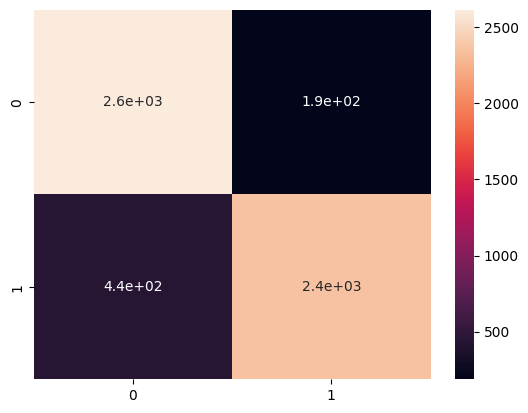

In [132]:
import seaborn as sns
sns.heatmap(cm, annot=True)

In [133]:
n_words=70000
LSTM_model = Sequential()
LSTM_model.add(Embedding(n_words+1, 32))
LSTM_model.add(LSTM(32, activation='tanh'))
LSTM_model.add(Dense(1, activation='sigmoid'))

In [134]:
# Compiling
LSTM_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=["accuracy"])
# Checking summary
LSTM_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 32)          2240032   
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,248,385
Trainable params: 2,248,385
Non-trainable params: 0
_________________________________________________________________


In [135]:
n_epochs = 15                    # Number of epochs.
batch_size = 32                   # Size of each batch.
learn_rate = 0.002               # learning rate.

In [136]:
# Optimizer and compilation.
my_optimizer=Adam(learn_rate)
LSTM_model.compile(loss = "binary_crossentropy", optimizer = my_optimizer, metrics=["accuracy"])

In [137]:
my_summary = LSTM_model.fit(train, epochs=n_epochs, batch_size = batch_size, validation_data=val, verbose = 1)

Epoch 1/15
489/489 [==============================] - 23s 48ms/step - loss: 0.5001 - accuracy: 0.7618 - val_loss: 0.4686 - val_accuracy: 0.7830
Epoch 2/15
489/489 [==============================] - 24s 50ms/step - loss: 0.3259 - accuracy: 0.8716 - val_loss: 0.3179 - val_accuracy: 0.8859
Epoch 3/15
489/489 [==============================] - 25s 50ms/step - loss: 0.2517 - accuracy: 0.9119 - val_loss: 0.2076 - val_accuracy: 0.9326
Epoch 4/15
489/489 [==============================] - 24s 50ms/step - loss: 0.2448 - accuracy: 0.9172 - val_loss: 0.1812 - val_accuracy: 0.9415
Epoch 5/15
489/489 [==============================] - 24s 49ms/step - loss: 0.1859 - accuracy: 0.9391 - val_loss: 0.1621 - val_accuracy: 0.9480
Epoch 6/15
489/489 [==============================] - 26s 53ms/step - loss: 0.1563 - accuracy: 0.9512 - val_loss: 0.1324 - val_accuracy: 0.9609
Epoch 7/15
489/489 [==============================] - 26s 52ms/step - loss: 0.1442 - accuracy: 0.9569 - val_loss: 0.1332 - val_accuracy:

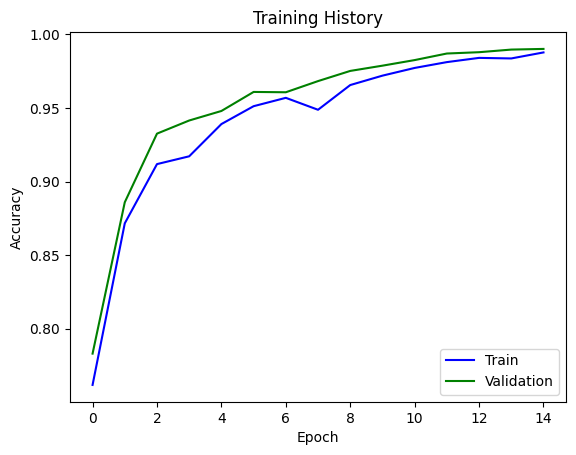

In [138]:
plt.plot(my_summary.history['accuracy'], c="b")
plt.plot(my_summary.history['val_accuracy'], c="g")
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

<Figure size 800x500 with 0 Axes>

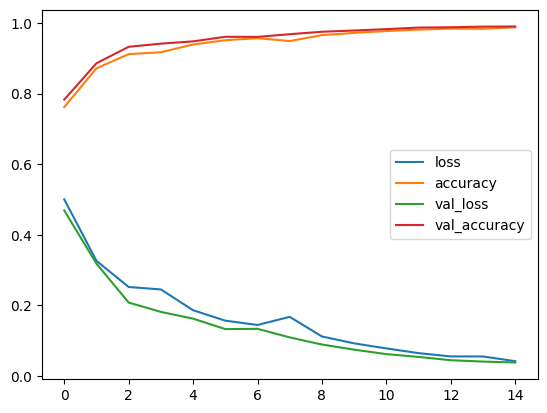

In [139]:
plt.figure(figsize=(8, 5))
pd.DataFrame(my_summary.history).plot()
plt.show()

In [140]:
# Classification Report for GRU Model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89      2802
           1       0.93      0.84      0.88      2794

    accuracy                           0.89      5596
   macro avg       0.89      0.89      0.89      5596
weighted avg       0.89      0.89      0.89      5596



In [141]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)


Accuracy: 0.8879556826304503
Precision: 0.9264069264069265
Recall: 0.84251968503937


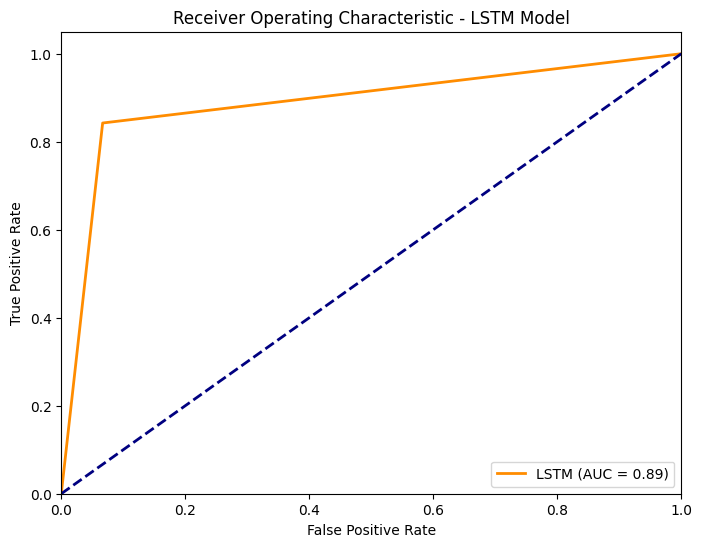

In [142]:
# ROC Curve for GRU Model
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_pred)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)
plt.figure(figsize=(8, 6))
plt.plot(fpr_lstm, tpr_lstm, color='darkorange', lw=2, label='LSTM (AUC = %0.2f)' % roc_auc_lstm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - LSTM Model')
plt.legend(loc="lower right")
plt.show()

**GRU Model**

In [143]:
# GRU model
model_gru = Sequential()
model_gru.add(Embedding(n_words, 32))
model_gru.add(GRU(32, activation='tanh'))
model_gru.add(Dense(1, activation='sigmoid'))

In [144]:
model_gru.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=["accuracy"])
# Checking summary
model_gru.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 32)          2240000   
                                                                 
 gru_2 (GRU)                 (None, 32)                6336      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,246,369
Trainable params: 2,246,369
Non-trainable params: 0
_________________________________________________________________


In [145]:
model_gru_history = model_gru.fit(vectorizerd_text, y_train, epochs=5, validation_data=(vectorizerd_text2, y_test))

Epoch 1/5
  2/700 [..............................] - ETA: 36s - loss: 0.6989 - accuracy: 0.2812

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


700/700 [==============================] - 40s 57ms/step - loss: 0.4420 - accuracy: 0.8112 - val_loss: 0.3876 - val_accuracy: 0.8767
Epoch 2/5
700/700 [==============================] - 39s 56ms/step - loss: 0.3699 - accuracy: 0.8666 - val_loss: 0.3470 - val_accuracy: 0.8772
Epoch 3/5
700/700 [==============================] - 44s 63ms/step - loss: 0.2866 - accuracy: 0.9020 - val_loss: 0.3349 - val_accuracy: 0.8481
Epoch 4/5
700/700 [==============================] - 40s 58ms/step - loss: 0.2304 - accuracy: 0.9194 - val_loss: 0.2746 - val_accuracy: 0.8896
Epoch 5/5
700/700 [==============================] - 41s 58ms/step - loss: 0.1722 - accuracy: 0.9398 - val_loss: 0.2255 - val_accuracy: 0.9169


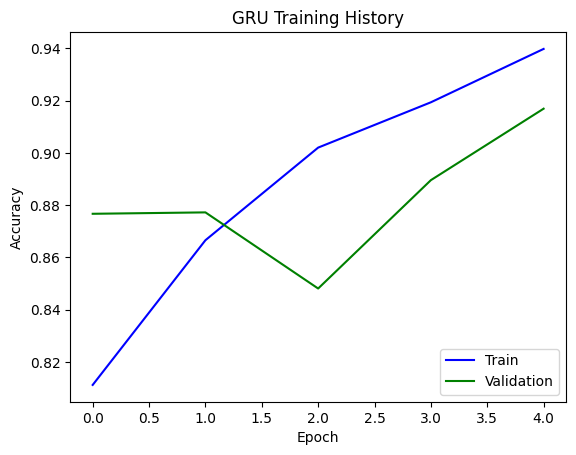

In [146]:
# Plot training history
plt.plot(model_gru_history.history['accuracy'], c="b")
plt.plot(model_gru_history.history['val_accuracy'], c="g")
plt.title('GRU Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()


In [147]:
# Predict using the GRU model
predictions_gru = model_gru.predict(vectorizerd_text2)

# Round predictions to 0 or 1
y_pred_gru = [round(x[0]) for x in predictions_gru]

# Create a DataFrame with actual and predicted labels

df_test_gru = pd.DataFrame({
    'label': y_test,
    'label_pred': y_pred_gru
})

# Display the first few rows of the DataFrame
df_test_gru.head()


175/175 [==============================] - 2s 10ms/step


,label,label_pred
6604,1,1
25912,1,1
18308,0,0
18875,1,1
23181,0,0


 10/175 [>.............................] - ETA: 1s

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


175/175 [==============================] - 2s 10ms/step


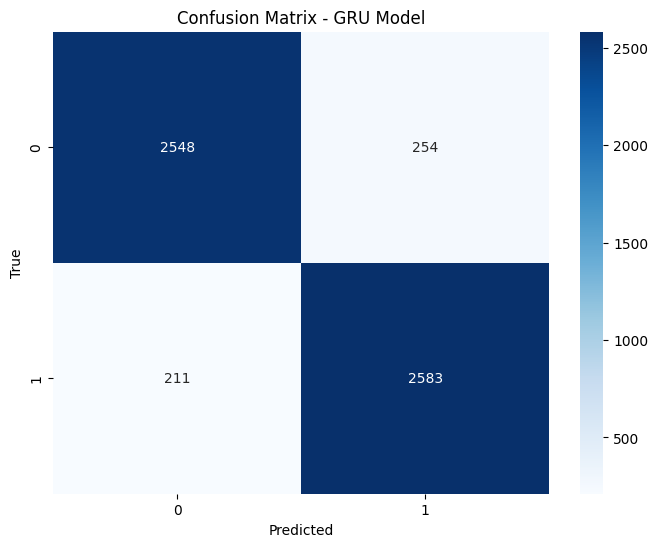

In [148]:
# Confusion Matrix for GRU Model
predictions_gru = model_gru.predict(vectorizerd_text2)
y_pred_gru = [round(x[0]) for x in predictions_gru]
cm_gru = confusion_matrix(y_test, y_pred_gru)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - GRU Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [149]:
# Compiling
model_gru.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=["accuracy"])
# Checking summary
model_gru.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 32)          2240000   
                                                                 
 gru_2 (GRU)                 (None, 32)                6336      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,246,369
Trainable params: 2,246,369
Non-trainable params: 0
_________________________________________________________________


In [150]:
# Optimizer and compilation.
my_optimizer=Adam(learn_rate)
model_gru.compile(loss = "binary_crossentropy", optimizer = my_optimizer, metrics=["accuracy"])

In [151]:
myGRU_summary = model_gru.fit(train, epochs=n_epochs, batch_size = batch_size, validation_data=val, verbose = 1)

Epoch 1/15
489/489 [==============================] - 22s 46ms/step - loss: 0.1443 - accuracy: 0.9489 - val_loss: 0.1062 - val_accuracy: 0.9643
Epoch 2/15
489/489 [==============================] - 23s 47ms/step - loss: 0.1128 - accuracy: 0.9595 - val_loss: 0.0933 - val_accuracy: 0.9712
Epoch 3/15
489/489 [==============================] - 22s 45ms/step - loss: 0.0905 - accuracy: 0.9689 - val_loss: 0.0697 - val_accuracy: 0.9768
Epoch 4/15
489/489 [==============================] - 23s 46ms/step - loss: 0.0742 - accuracy: 0.9744 - val_loss: 0.0512 - val_accuracy: 0.9828
Epoch 5/15
489/489 [==============================] - 23s 47ms/step - loss: 0.0651 - accuracy: 0.9781 - val_loss: 0.0512 - val_accuracy: 0.9839
Epoch 6/15
489/489 [==============================] - 23s 46ms/step - loss: 0.0559 - accuracy: 0.9814 - val_loss: 0.0312 - val_accuracy: 0.9913
Epoch 7/15
489/489 [==============================] - 22s 46ms/step - loss: 0.0435 - accuracy: 0.9846 - val_loss: 0.0348 - val_accuracy:

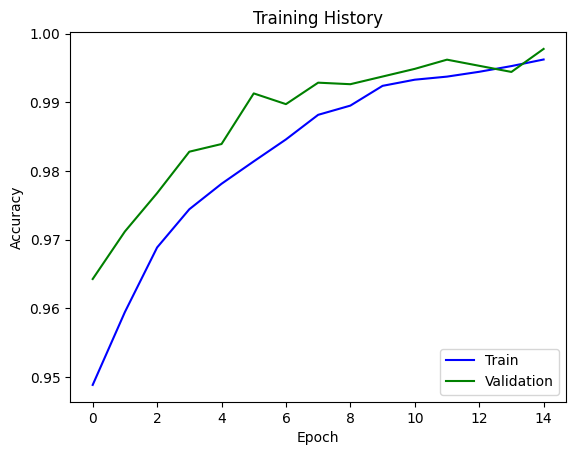

In [152]:
plt.plot(myGRU_summary.history['accuracy'], c="b")
plt.plot(myGRU_summary.history['val_accuracy'], c="g")
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

<Figure size 800x500 with 0 Axes>

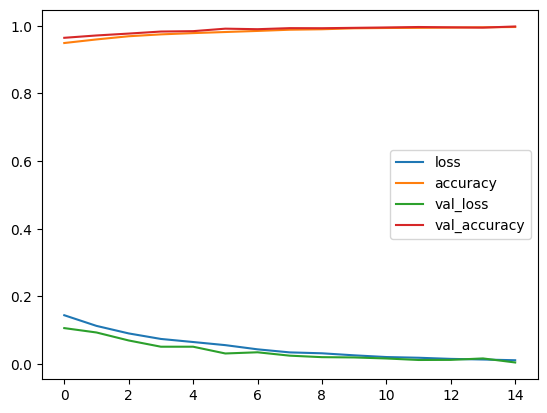

In [153]:
plt.figure(figsize=(8, 5))
pd.DataFrame(myGRU_summary.history).plot()
plt.show()

In [154]:
# Importing necessary modules
from sklearn.metrics import *

# Classification Report for GRU Model
print(classification_report(y_test, y_pred_gru))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      2802
           1       0.91      0.92      0.92      2794

    accuracy                           0.92      5596
   macro avg       0.92      0.92      0.92      5596
weighted avg       0.92      0.92      0.92      5596



In [155]:
# ROC Curve for GRU Model
fpr_gru, tpr_gru, _ = roc_curve(y_test, predictions_gru)
roc_auc_gru = auc(fpr_gru, tpr_gru)

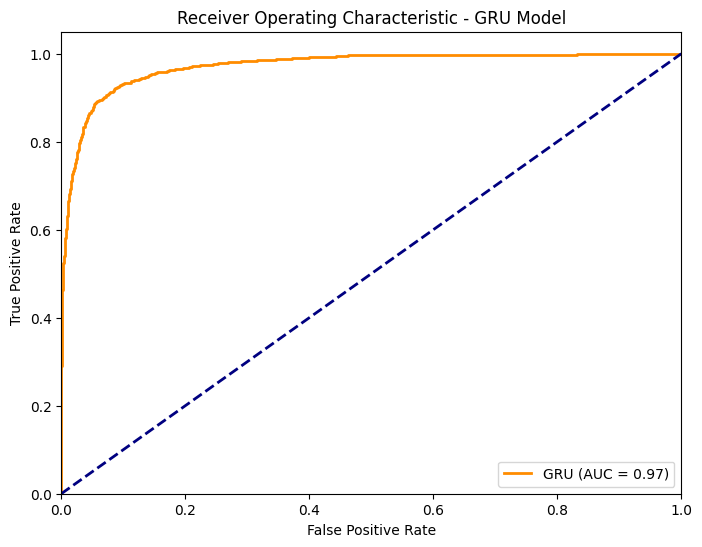

In [156]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_gru, tpr_gru, color='darkorange', lw=2, label='GRU (AUC = %0.2f)' % roc_auc_gru)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - GRU Model')
plt.legend(loc="lower right")
plt.show()

In [159]:
accuracy_lstm = accuracy_score(y_test, y_pred)
precision_lstm = precision_score(y_test, y_pred)
recall_lstm = recall_score(y_test, y_pred)

# Calculate metrics for GRU
accuracy_gru = accuracy_score(y_test, y_pred_gru)
precision_gru = precision_score(y_test, y_pred_gru)
recall_gru = recall_score(y_test, y_pred_gru)

# Print the metrics for both models
print("LSTM Performance:")
print("Accuracy:", accuracy_lstm)
print("Precision:", precision_lstm)
print("Recall:", recall_lstm)

print("\nGRU Performance:")
print("Accuracy:", accuracy_gru)
print("Precision:", precision_gru)
print("Recall:", recall_gru)

LSTM Performance:
Accuracy: 0.8879556826304503
Precision: 0.9264069264069265
Recall: 0.84251968503937

GRU Performance:
Accuracy: 0.9169049320943531
Precision: 0.9104688050757843
Recall: 0.9244810307802434
